# Introduction

The presence and harmful abundance models are applied in a seasonal time series of four chosen regions to illustrate the model's applicability.

# 1. Library

In [1]:
import os
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


# 2. Set the paths

In [2]:
# Local path
path = os.getcwd()

# Path for the hab database
path_cells = os.path.join(path, "00_database", "db.csv")

# Path for the calibrated presence models
alg_path = os.path.join(path, "00_output", "01_ml_models", "ml_dict.pickle")

# Path for the calibrated HC models
alg_path_hab = os.path.join(path, "00_output", "01_ml_models", "ml_dict_hab.pickle")

# Path for the environmental conditions on each farm
path_aux = os.path.join(path, "00_database", "regions_ts")

# Path for saving figure
path_out_fig = os.path.join(path, "00_figures")

# 3. Configurate experiment

In [3]:
# Period for computing the seasonal probability
year_start = 2014
year_end = 2019

# Species to apply presence probability models
species_list = ["A. sp.", 'A. tamarense', 'D. acuta', 'D. acuminata', "D. norvegica", "Pn. sp.", "P. reticulatum", "A. spinosum"]

# Species to apply HC probability models
hab_species_list = ["A. sp.", 'A. tamarense', 'D. acuta', "A. spinosum"]

# HC thresholds for each alga
hab_thresholds = {
    "D. acuminata": 1000,
    "D. acuta": 200,
    "A. tamarense": 200,
    "D. norvegica": 4000,
    "Pn. sp.": 1000000,
    "P. reticulatum": 1000,
    "A. sp.": 200,
    "A. spinosum": 3600
}

# Predictors
predictors = ["sst", "mld", "sss", "par"]

# Regions
regions = ['Arendal', 'Bømlo', 'Vesterålen', 'Nærøy']

# 4. Read files

In [4]:
# Read cell database
df_cell = pd.read_csv(path_cells)
df_cell['Date'] = pd.to_datetime(df_cell['Date'])
df_cell = df_cell[(df_cell['Date'].dt.year >= year_start) & (df_cell['Date'].dt.year <= year_end)]
df_cell = df_cell.join(pd.DataFrame(df_cell['Date'].dt.isocalendar().week.values,
                                     columns=["Week"],
                                     index=df_cell.index))

df_cell = df_cell[species_list + ["Date", "Region", "Week"]]
for spec in species_list:
    df_cell[spec] = (df_cell[spec] > hab_thresholds[spec]).astype(int)

# Read environmental factors for each station
df_pred = pd.DataFrame()  # Initialize an empty DataFrame to hold the results

for reg in regions:
    df_reg_i = pd.read_csv(os.path.join(path_aux, f"{reg}.csv"))
    df_reg_i['Date'] = pd.to_datetime(df_reg_i['Date'])
    df_reg_i = df_reg_i[(df_reg_i['Date'].dt.year >= year_start) & (df_reg_i['Date'].dt.year <= year_end)]
    df_reg_i = df_reg_i.set_index("Date")
    df_reg_i = df_reg_i.interpolate(method="linear", axis=0, limit=8, limit_read="inside")
    df_reg_i["Week"] = df_reg_i.index.isocalendar().week
    df_reg_i = df_reg_i.fillna(0)  # Assumes PAR during the winter is 0
    df_reg_i = df_reg_i.resample('W-Mon').first()  # Resample to every Monday
    df_reg_i["Region"] = reg
    df_reg_i = df_reg_i.reset_index()
    df_pred = pd.concat([df_pred, df_reg_i])


# 5. Read ML models

In [5]:
with open(alg_path, "rb") as input_file:
    models_dict = pickle.load(input_file)

# Add a blank line for separation
with open(alg_path_hab, "rb") as input_file:
    modelshab_dict = pickle.load(input_file)


# 6. Apply the ML models to the aux data

In [6]:
# Presence model
predicted_presence_dict = {}

for spec in species_list:
    # select model
    ml_model = models_dict[spec]
    predicted_df_list = []

    for reg in regions:
        # subset region
        subset_df = df_pred[df_pred.Region == reg]
        X = subset_df[predictors]

        # predict probability
        y_predicted = ml_model.predict_proba(X)[:, 1] * 100
        predicted_df_i = pd.DataFrame(y_predicted, index=subset_df.index, columns=["Probability"])
        predicted_df_i = predicted_df_i.join(subset_df[["Region", "Date", "Week"]])
        predicted_df_i["Week"] = predicted_df_i["Week"].astype(float)

        predicted_df_list.append(predicted_df_i)

    # concatenate results for the current species
    predicted_df_species = pd.concat(predicted_df_list, ignore_index=True)

    # save results
    predicted_presence_dict[spec] = predicted_df_species


In [7]:
# Presence model
predicted_hab_dict = {}

for spec in species_list:
    # select model
    ml_model = modelshab_dict[spec]
    predicted_df_list = []

    for reg in regions:
        # subset region
        subset_df = df_pred[df_pred.Region == reg]
        X = subset_df[predictors]

        # predict probability
        y_predicted = ml_model.predict_proba(X)[:, 1] * 100
        predicted_df_i = pd.DataFrame(y_predicted, index=subset_df.index, columns=["Probability"])
        predicted_df_i = predicted_df_i.join(subset_df[["Region", "Date", "Week"]])
        predicted_df_i["Week"] = predicted_df_i["Week"].astype(float)

        predicted_df_list.append(predicted_df_i)

    # concatenate results for the current species
    predicted_df_species = pd.concat(predicted_df_list, ignore_index=True)

    # save results
    predicted_hab_dict[spec] = predicted_df_species


# 7. Plot seasonal presence probability

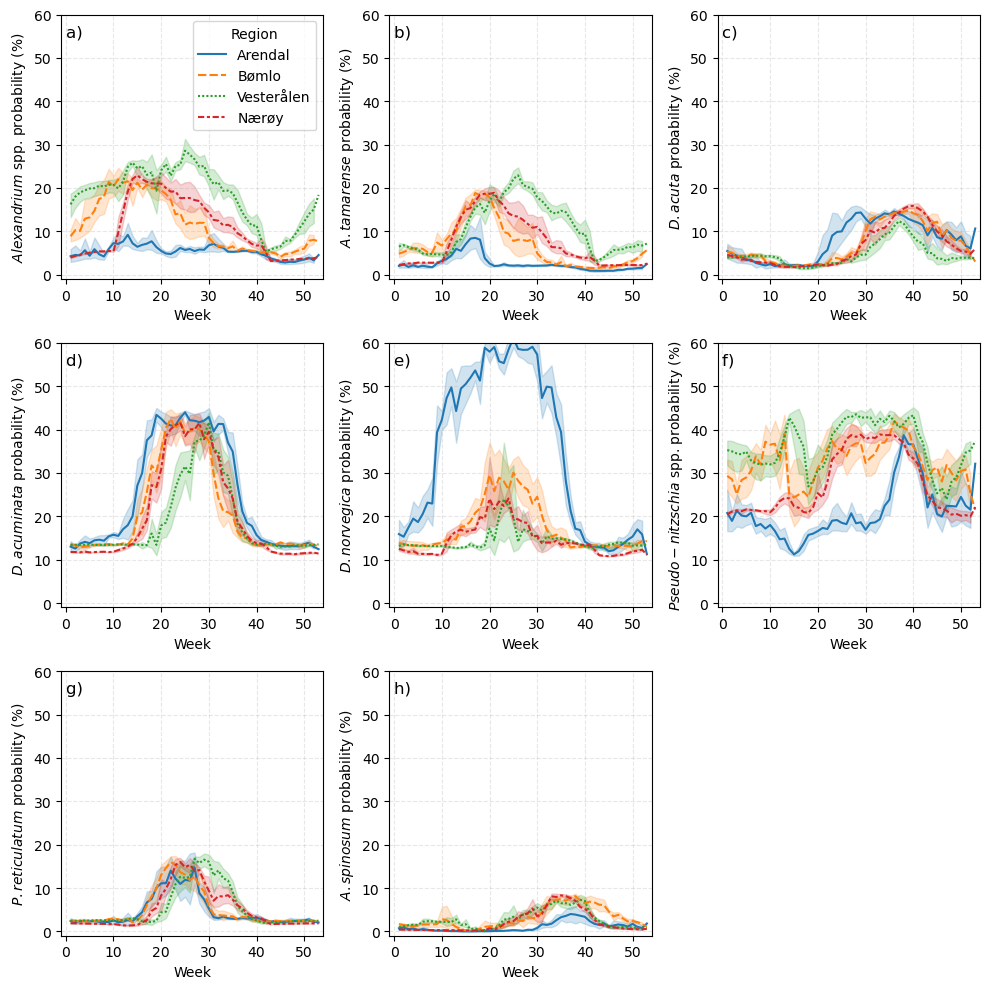

In [8]:
# Set taxa names to show in plot
species_names = {
    "A. sp.": "$\it{Alexandrium}$ spp.",
    'A. tamarense': "$\it{A. tamarense}$",
    'D. acuta': "$\it{D. acuta}$",
    'D. acuminata': "$\it{D. acuminata}$",
    "D. norvegica": "$\it{D. norvegica}$",
    "Pn. sp.": "$\it{Pseudo-nitzschia}$ spp.",
    "P. reticulatum": "$\it{P. reticulatum}$",
    "A. spinosum": "$\it{A. spinosum}$"
}

# Start plot
fig = plt.figure(figsize=(10, 10))

# Loop through each species
for i, spec in enumerate(species_list, start=1):
    # Select subplot to show legend
    show_legend = i == 1
    
    # Subset the taxa to plot
    subset_df = predicted_presence_dict[spec]

    # Plot
    ax = plt.subplot(3, 3, i)
    
    sns.lineplot(
        x="Week",
        y="Probability",
        hue="Region",
        style="Region",
        data=subset_df,
        errorbar=('ci', 95),
        legend=show_legend,
        ax=ax
    )

    # Plot formatting
    ax.set_ylim((-1, 60))
    ax.set_xlim((-1, 54))
    ax.grid(linestyle="--", alpha=0.3)
    ax.set_ylabel(species_names[spec] + " probability (%)")
    ax.text(0, 55, chr(ord('`') + i) + ") ", fontsize=12)

# Adjust layout
plt.tight_layout()

# Save plot
fig.savefig(path_out_fig + "/seasonal_ts.png", dpi=300)


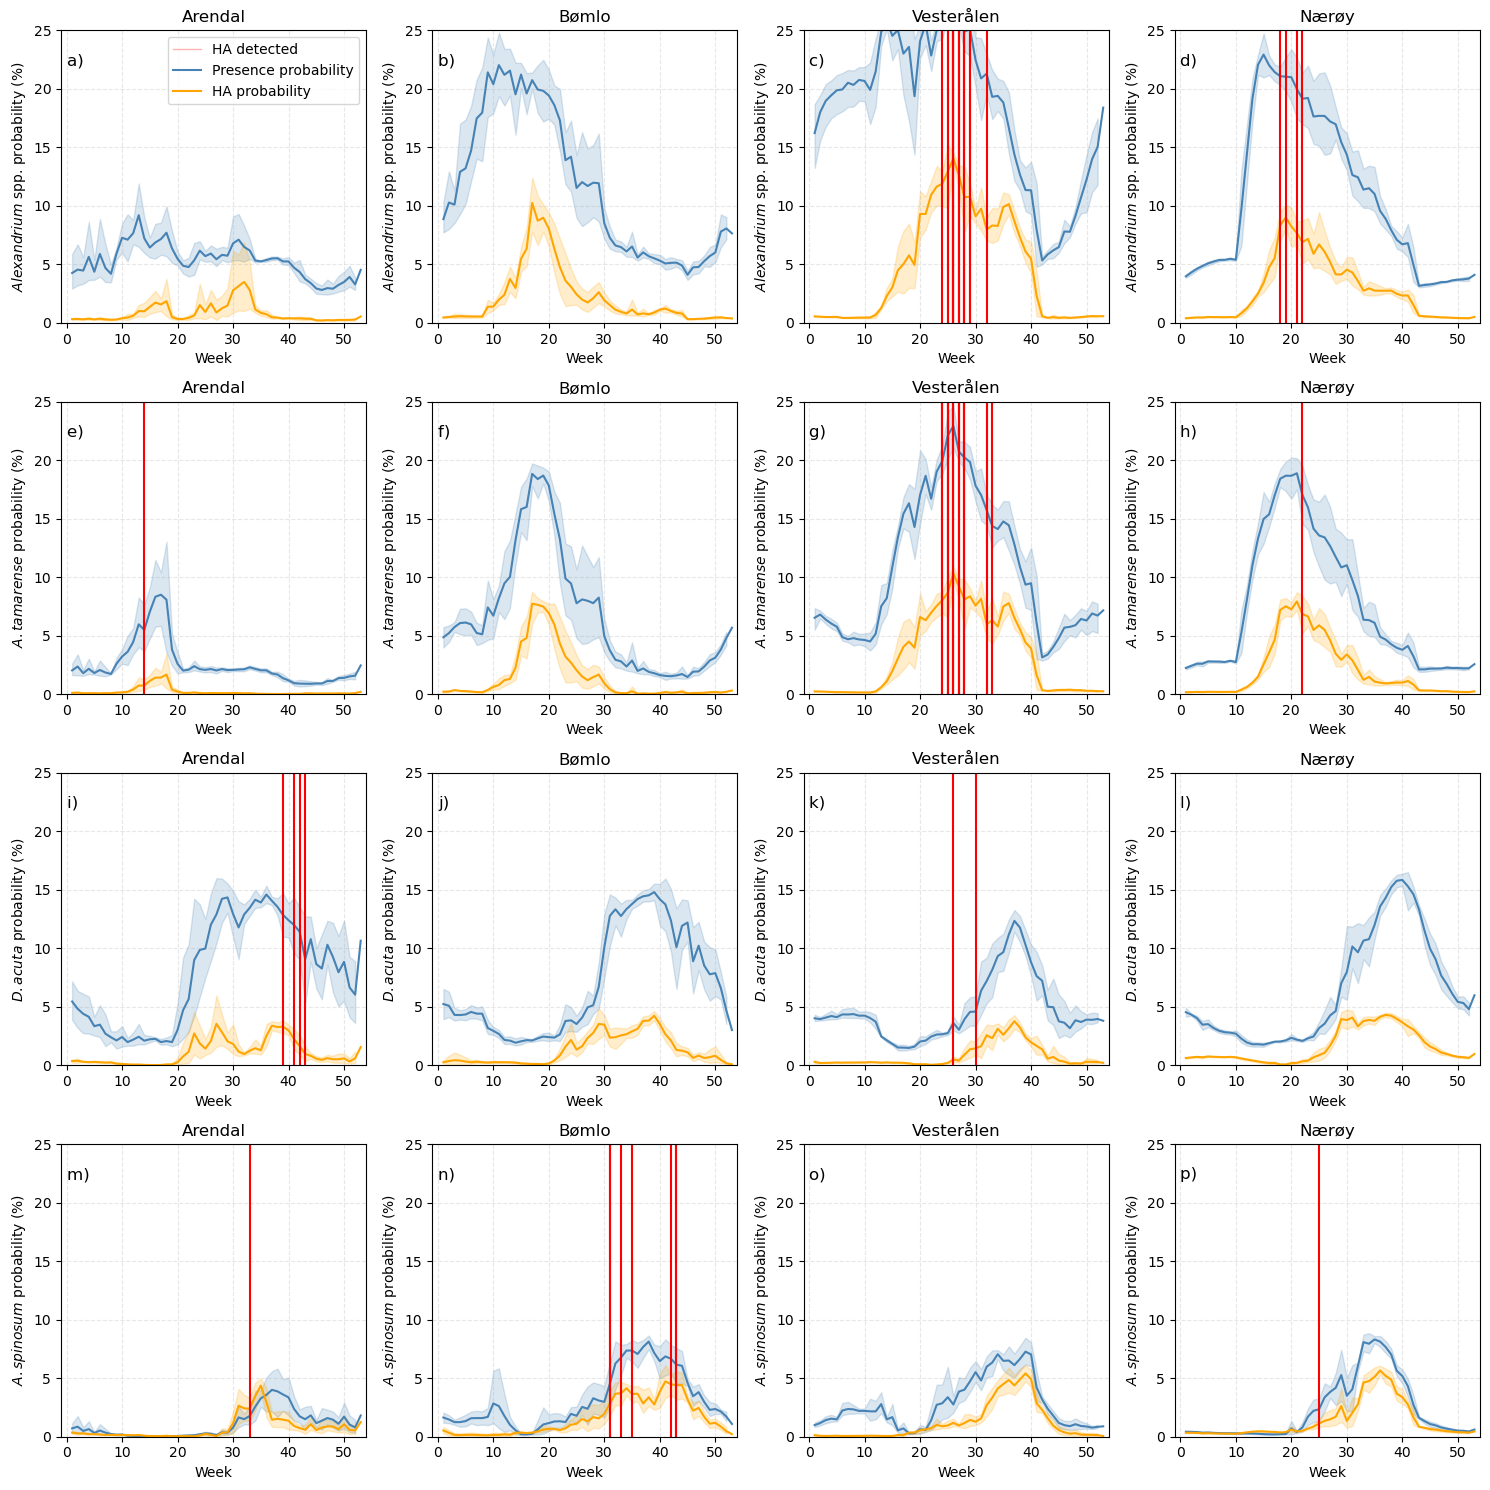

In [9]:
# Set legend style
legend_elements = [
    Line2D([0], [0], color='r', lw=1, label='HA detected', alpha=0.3),
    Line2D([0], [0], color='steelblue', label='Presence probability'),
    Line2D([0], [0], color='orange', label='HA probability')
]

# Start plot
fig = plt.figure(figsize=(15, 15))

# Loop through each species and region
i = 1
for spec in hab_species_list:
    for reg in regions:
        # Subset presence probability
        subset_presence_prob = predicted_presence_dict[spec]
        subset_presence_prob = subset_presence_prob[subset_presence_prob["Region"] == reg]

        # Subset HC probability
        subset_hab_prob = predicted_hab_dict[spec]
        subset_hab_prob = subset_hab_prob[subset_hab_prob["Region"] == reg]

        # Subset HABs detected
        subset_cell = df_cell[(df_cell.Region == reg) & (df_cell[spec] == 1)]

        # Plot
        ax = plt.subplot(len(hab_species_list), len(regions), i)

        sns.lineplot(x="Week", y="Probability", data=subset_presence_prob, color='steelblue', ax=ax)
        sns.lineplot(x="Week", y="Probability", data=subset_hab_prob, color='orange', ax=ax)

        if not subset_cell.empty:
            for week in subset_cell["Week"]:
                ax.vlines(x=week, ymin=0, ymax=25, color="r")

        # Plot formatting
        ax.set_ylim((0, 25))
        ax.set_xlim((-1, 54))
        ax.text(0, 22, chr(ord('`') + i) + ") ", fontsize=12)
        ax.grid(linestyle="--", alpha=0.3)
        ax.set_ylabel(species_names[spec] + " probability (%)")
        ax.set_title(reg)

        # Add legend to the first subplot
        if i == 1:
            ax.legend(handles=legend_elements, loc=1)

        i = i + 1

plt.tight_layout()

# Save plot
fig.savefig(path_out_fig + "/hab_x_presence_seasonal.png", dpi=300)
